In [ ]:
# -*- coding: utf-8 -*-
"""SAM/AAO_2021

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1XBv1kTcbd8JMtm5U0RPl8qy6-tg5DXZ3
"""

# Commented out IPython magic to ensure Python compatibility.
#Criado por Natália Crespo
!pip install NetCDF4

!pip install importlib-metadata==4.0.1
!pip install xarray==0.18.1

import xarray as xr #pacote para abrir e trabalhar com o netcdf

#import matplotlib.pyplot as plt #pacote para plot
import numpy as np #pacote para comandos gerais com os dados
#import os
from sklearn import preprocessing #pacote para pre-processar dados para cálculos de forma geral https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.decomposition import PCA #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
import pickle #pacote para serializar dados https://docs.python.org/3/library/pickle.html
from scipy.signal import detrend #pacote estatístico para remover tendência
import statsmodels.api as sm #https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.seasonal.seasonal_decompose/

#!pip install proplot
#import proplot as plot
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"
from mpl_toolkits.basemap import Basemap
#from mpl_toolkits.basemap import Basemap #pacote para mapas
import matplotlib.pyplot as plt #pacote para plot
# %matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looki

In [ ]:
#Função que calcula anomalia com base em todo o período
def calc_anom(arq):
    arq_clima = arq.groupby('time.month').mean(dim='time', skipna=False)
    anom = arq.groupby("time.month") - arq_clima  # calculando anomalia
    return anom

arq = xr.open_dataset('hgt_79a00_700hsmonCal.nc', decode_times=False) #ERAI15
arq=arq.squeeze('levelist')
print(arq)
arq

time=xr.cftime_range(start='1979-01-01', freq="M", periods=12 * 23)
da = xr.DataArray(arq.z,dims=['time','latitude','longitude'],coords={'time': time, 'latitude': arq.latitude,'longitude': arq.longitude})

#time
#da

da= calc_anom(da)  # calculando anomalia

#da.values

#Reshape em matriz 2D
lat = da['latitude'].values
lon = da['longitude'].values
z=da.values
lons, lats = np.meshgrid(lon, lat)
arq_anom = np.reshape(z, (da.shape[0], len(lat) * len(lon)), order='F')  # numpy.ndarray

#arq_anom.shape
#lat

#Normalizando os dados
#scaler = preprocessing.StandardScaler() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#scaler_sst = scaler.fit(arq_anom)
#norm_anom = scaler_sst.transform(arq_anom)
#Removendo a tendência
arq_anom = detrend(arq_anom)
#Removendo a sazonalidade
#anom=sm.tsa.seasonal_decompose(arq_anom, freq=12)
#arq_anom=anom.seasonal

#arq_anom

<xarray.Dataset>
Dimensions:    (latitude: 47, longitude: 240, time: 276)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 -21.0 -22.5 -24.0 -25.5 ... -87.0 -88.5 -90.0
    levelist   float64 700.0
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 272.0 273.0 274.0 275.0
Data variables:
    z          (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.2 (http://code.zmaw.de/p...
    history:      Thu Apr 09 19:22:11 2020: cdo settaxis,1979-01-01,00:00,1mo...
    Conventions:  CF-1.0
    CDO:          Climate Data Operators version 1.6.2 (http://code.zmaw.de/p...


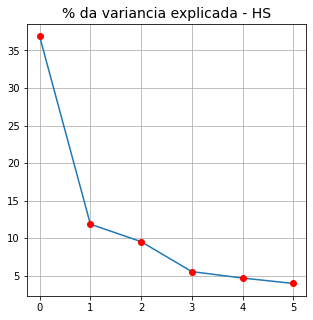

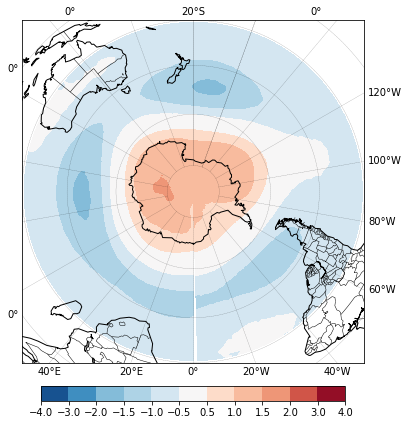

In [ ]:
# Aplicando PCA
skpca = PCA()
skpca = skpca.fit(arq_anom)
ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.70)[0][0] # extraindo o numero de CPs que explicam 70% da variancia original

#Plotando gráfico de variância explicada
f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:ipc+1]*100)
ax.plot(skpca.explained_variance_ratio_[0:ipc+1]*100,'ro')
ax.set_title("% da variancia explicada - HS", fontsize=14)
ax.grid()
#plt.savefig('PCS_variancia_explicada_HS.png')
plt.show()

ipc_explained_var = skpca.explained_variance_ratio_[0:ipc]

#ipc_explained_var

#Obtendo as PCs
PCs = skpca.transform(arq_anom)
PCs = PCs[:, :ipc]

#Extraindo as PCs
EOFs = skpca.components_
EOFs = EOFs[:ipc, :]

EOFs = np.reshape(EOFs, (ipc, len(lat), len(lon)), order='F')

EOFs = xr.DataArray(EOFs)
EOFs['dim_0'] = range(1, ipc+1, 1)
EOFs['dim_1'] = lat
EOFs['dim_2'] = lon
EOFs = EOFs.rename({'dim_0': 'PC'})
EOFs = EOFs.rename({'dim_1': 'lat'})
EOFs = EOFs.rename({'dim_2': 'lon'})

levels=[-4,-3,-2,-1.5,-1,-0.5,0.5,1,1.5,2,3,4]
fig, ax = plt.subplots(1,figsize=(7,7))
plt.figure(1)
m = Basemap(projection='splaea',boundinglat=-20,lon_0=0,resolution='c')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawparallels(np.arange(-80.,81.,20.),labels=[1, 0, 1, 0], linewidth=0.2)
m.drawmeridians(np.arange(-180.,210.,20.),labels=[0, 1, 0, 1], linewidth=0.2)
x, y = np.meshgrid(lon, lat)
mlon, mlat = m(x, y)
c = plt.contourf(mlon,mlat,EOFs.sel(PC=1)*100, levels=levels, cmap=plt.cm.RdBu_r) #muda os PCA=1,2,3
cbar = plt.colorbar(c, ticks= levels, orientation="horizontal", fraction=0.04, pad=0.06)